Per Capita Income Consolidation (1950–Present)

Countries: Singapore, Taiwan, South Korea, Japan

This notebook fetches and consolidates per capita income data from DGBAS and World Bank into an Excel file.

📘 Step 1: Replace DGBAS.xlsx file and clean Taiwan GNI Data from DGBAS.xlsx into Taiwan.xlsx

In [1]:
## Import necessary libraries
import pandas as pd

# Load the raw DGBAS file
raw_df = pd.read_excel("dgbas.xlsx", header=None)

# Extract the useful data range
# Real data starts at row 4 (index 4)
data_block = raw_df.iloc[4:, [0, 1, 9, 10, 11]]
data_block.columns = ["Year", "Population", "GNI_CurrentUSD_million", "PerCapitaGNI_NT", "PerCapitaIncome_CurrentUSD"]

# Drop rows where Year is not a valid number
data_block = data_block[pd.to_numeric(data_block["Year"], errors="coerce").notna()]
data_block["Year"] = data_block["Year"].astype(int)

# Add additional required columns for standardization
data_block["Country"] = "Taiwan"
data_block["Source"] = "DGBAS"
data_block["PerCapitaIncome_ConstantUSD"] = None
data_block["GDP_CurrentUSD"] = None
data_block["PPP_Adjusted"] = None

# Reorder columns
taiwan_clean = data_block[[
    "Country", "Year", "PerCapitaIncome_CurrentUSD", "PerCapitaIncome_ConstantUSD",
    "GDP_CurrentUSD", "Population", "PPP_Adjusted", "Source", "GNI_CurrentUSD_million"
]]

# Save to Excel
taiwan_clean.to_excel("taiwan.xlsx", index=False)
print("✅ Saved cleaned Taiwan data to taiwan.xlsx")

✅ Saved cleaned Taiwan data to taiwan.xlsx


🌍 Step 2: Fetch GDP per Capita for SG, JP, KR (World Bank via wbdata)

In [2]:
# Import libraries
import wbdata
import datetime

# Indicator and date range
indicator = {"NY.GDP.PCAP.CD": "PerCapitaIncome_CurrentUSD"}
data_date = (datetime.datetime(1960, 1, 1), datetime.datetime(2023, 1, 1))

# Country ISO3 codes
countries = {
    "SGP": "Singapore",
    "JPN": "Japan",
    "KOR": "Korea"
}

# Fetch data for each country
def fetch_from_wb(iso_list, country_name):
    df = wbdata.get_dataframe(indicator, country=iso_list, date=data_date)
    df.reset_index(inplace=True)
    df = df.rename(columns={
        "date": "Year",
        "country": "CountryCode",
        "PerCapitaIncome_CurrentUSD": "PerCapitaIncome_CurrentUSD",  # may already be set
        list(indicator.values())[0]: "PerCapitaIncome_CurrentUSD"  # auto rename the indicator column
    })

    df["Year"] = pd.to_datetime(df["Year"]).dt.year
    df["Country"] = country_name
    df["Source"] = "World Bank (wbdata)"
    df["PerCapitaIncome_ConstantUSD"] = None
    df["GDP_CurrentUSD"] = None
    df["Population"] = None
    df["PPP_Adjusted"] = None
    df["GNI_CurrentUSD_million"] = None

    return df[[
        "Country", "Year", "PerCapitaIncome_CurrentUSD", "PerCapitaIncome_ConstantUSD",
        "GDP_CurrentUSD", "Population", "PPP_Adjusted", "Source", "GNI_CurrentUSD_million"
    ]]

# Apply to all 3 countries
sg_df = fetch_from_wb(["SGP"], "Singapore")
jp_df = fetch_from_wb(["JPN"], "Japan")
kr_df = fetch_from_wb(["KOR"], "Korea")

# Combine and export
combined_wb = pd.concat([sg_df, jp_df, kr_df])
combined_wb.to_excel("openbb_countries.xlsx", index=False)
print("✅ Saved World Bank country data to openbb_countries.xlsx")

✅ Saved World Bank country data to openbb_countries.xlsx


🔗 Step 3: Combine Taiwan + World Bank Data

In [3]:
# Load both data sources
taiwan = pd.read_excel("taiwan.xlsx")
openbb_countries = pd.read_excel("openbb_countries.xlsx")

# Combine and sort
combined = pd.concat([taiwan, openbb_countries])
combined = combined.sort_values(by=["Country", "Year"]).reset_index(drop=True)

# Export final dataset
combined.to_excel("per_capita_income_consolidated.xlsx", index=False)
print("✅ Saved full dataset to per_capita_income_consolidated.xlsx")

✅ Saved full dataset to per_capita_income_consolidated.xlsx


📊 Optional: Preview Cleaned Data

In [4]:
# Load final dataset
df = pd.read_excel("per_capita_income_consolidated.xlsx")
df.head(10)

,Country,Year,PerCapitaIncome_CurrentUSD,PerCapitaIncome_ConstantUSD,GDP_CurrentUSD,Population,PPP_Adjusted,Source,GNI_CurrentUSD_million
0,Japan,1960,508.702779,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
1,Japan,1961,608.864581,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
2,Japan,1962,684.565510,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
3,Japan,1963,775.592123,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
4,Japan,1964,902.867722,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
5,Japan,1965,993.732722,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
6,Japan,1966,1143.607897,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
7,Japan,1967,1326.361039,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
8,Japan,1968,1553.271394,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN
9,Japan,1969,1802.980281,NaN,NaN,NaN,NaN,World Bank (wbdata),NaN


📈 Optional: Plot Per Capita Income Over Time

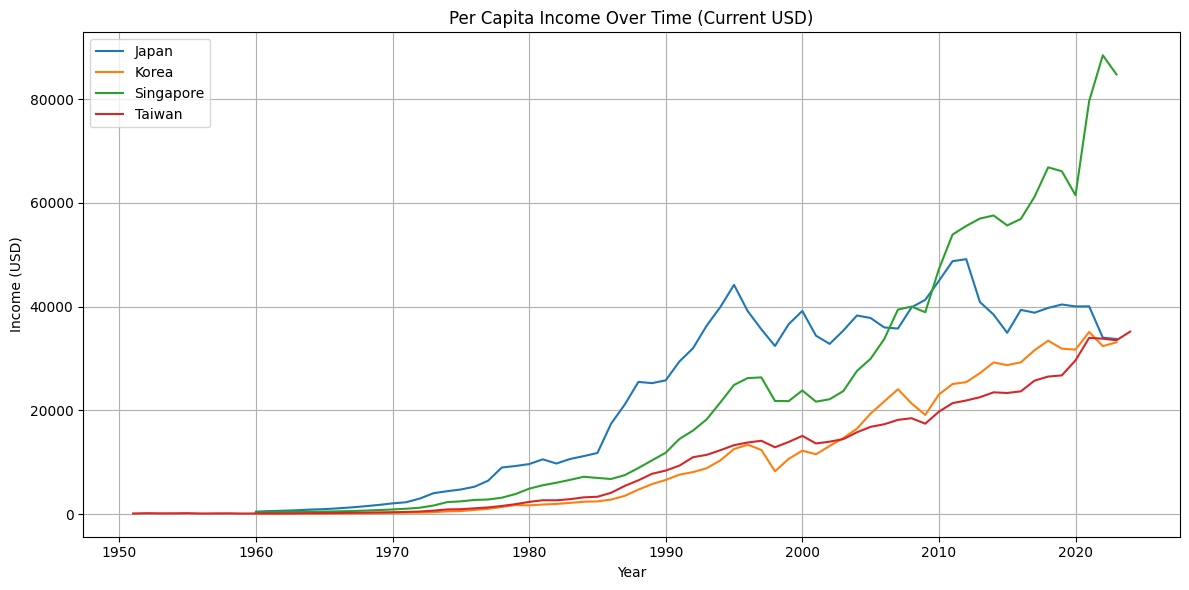

In [6]:
# Import libraries
import matplotlib.pyplot as plt

# Line plot: Per Capita Income over time by country
plt.figure(figsize=(12, 6))
for country in df["Country"].unique():
    subset = df[df["Country"] == country]
    plt.plot(subset["Year"], subset["PerCapitaIncome_CurrentUSD"], label=country)

plt.title("Per Capita Income Over Time (Current USD)")
plt.xlabel("Year")
plt.ylabel("Income (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📉 Optional: Histogram of Per Capita Income (All Years)

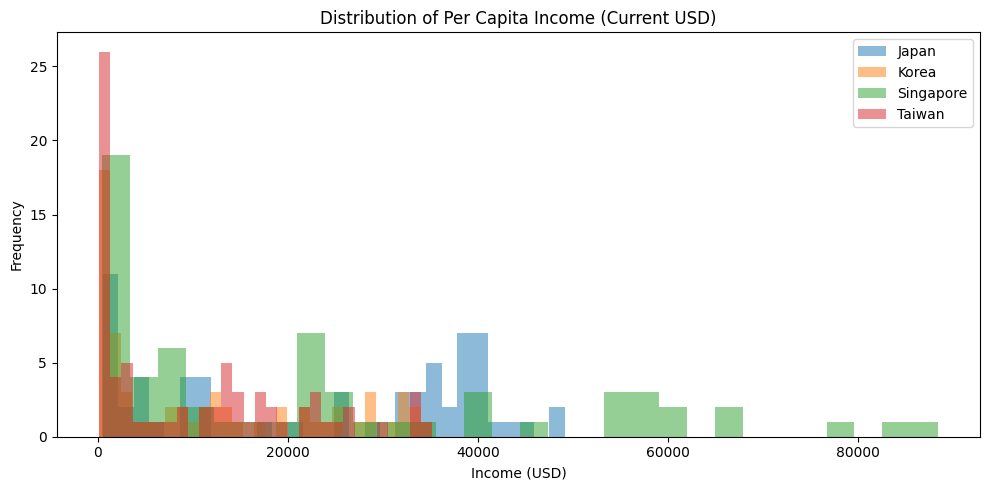

In [7]:
plt.figure(figsize=(10, 5))
for country in df["Country"].unique():
    subset = df[df["Country"] == country]
    plt.hist(subset["PerCapitaIncome_CurrentUSD"].dropna(), bins=30, alpha=0.5, label=country)

plt.title("Distribution of Per Capita Income (Current USD)")
plt.xlabel("Income (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

📊 Optional: Show Data Summary by Country

In [8]:
df.groupby("Country")["PerCapitaIncome_CurrentUSD"].describe()

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Japan,64.0,23438.066292,16567.629400,508.702779,5176.798441,30710.609558,38565.059668,49145.280431
Korea,64.0,11389.518842,11714.446523,93.831383,779.964671,7881.805063,21448.690348,35125.522498
Singapore,64.0,23373.110395,24676.596187,428.056183,2691.683179,15319.310266,39053.325582,88428.702423
Taiwan,74.0,9982.756757,10524.388830,140.000000,366.000000,6004.500000,17221.000000,35188.000000
